In [4]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [5]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

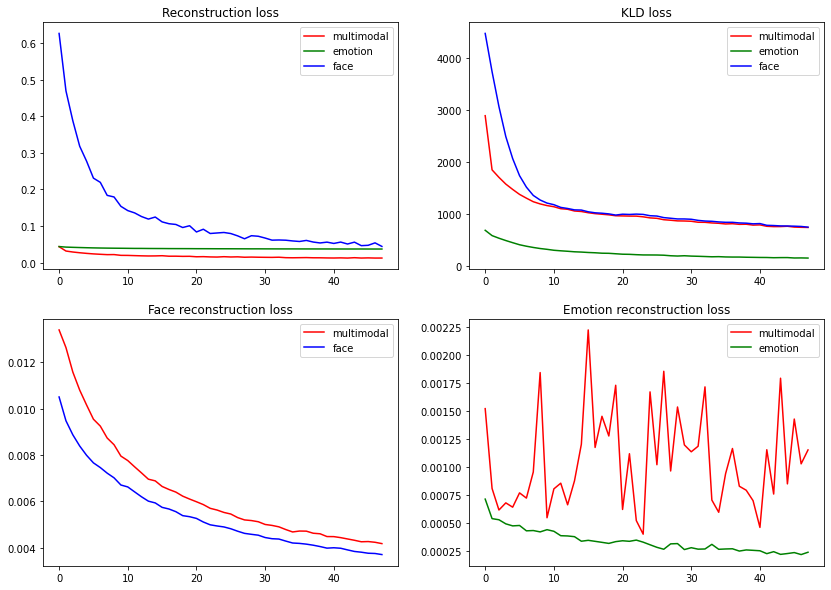

In [7]:
loaded_data = torch.load("../trained_models/ravdess_mvae_data_8k_altloss_01.save")
training_losses_8kaltloss = loaded_data['training_loss']
U.print_losses(training_losses_8kaltloss, 2)

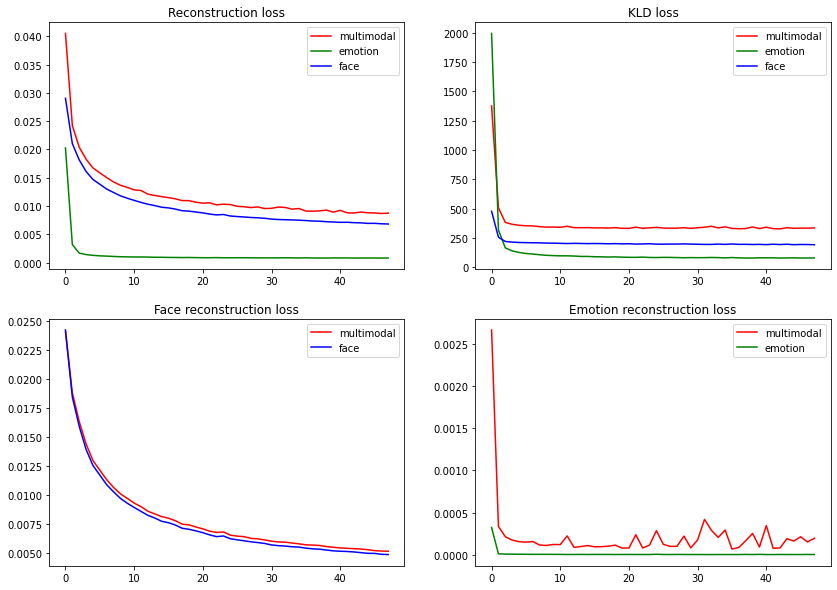

In [9]:
loaded_data = torch.load("../trained_models/ravdess_mvae_data_8kdrop.save")
training_losses_8kdrop_1_1 = loaded_data['training_loss']
U.print_losses(training_losses_8kdrop_1_1, 2)

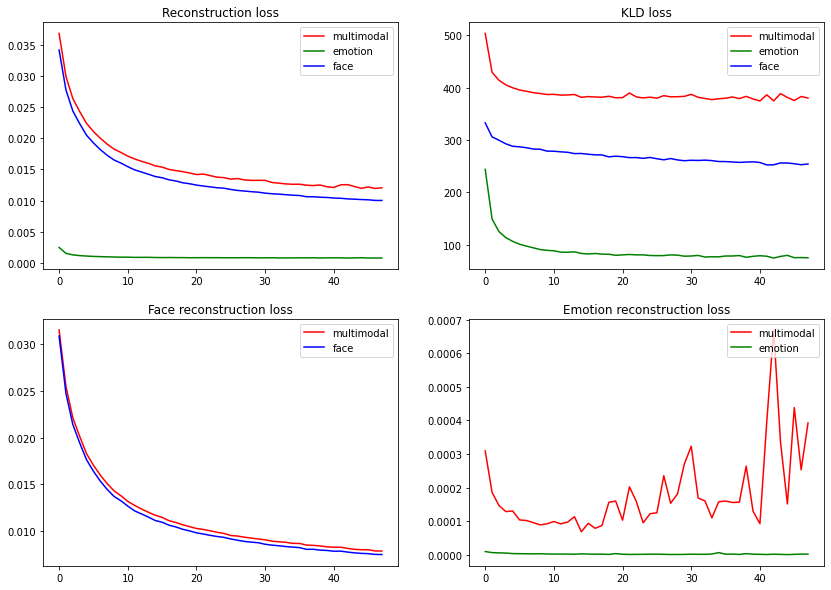

In [10]:
loaded_data = torch.load("../trained_models/ravdess_mvae_data_8kdrop_2-1.save")
training_losses_8kdrop_2_1 = loaded_data['training_loss']
U.print_losses(training_losses_8kdrop_2_1, 2)

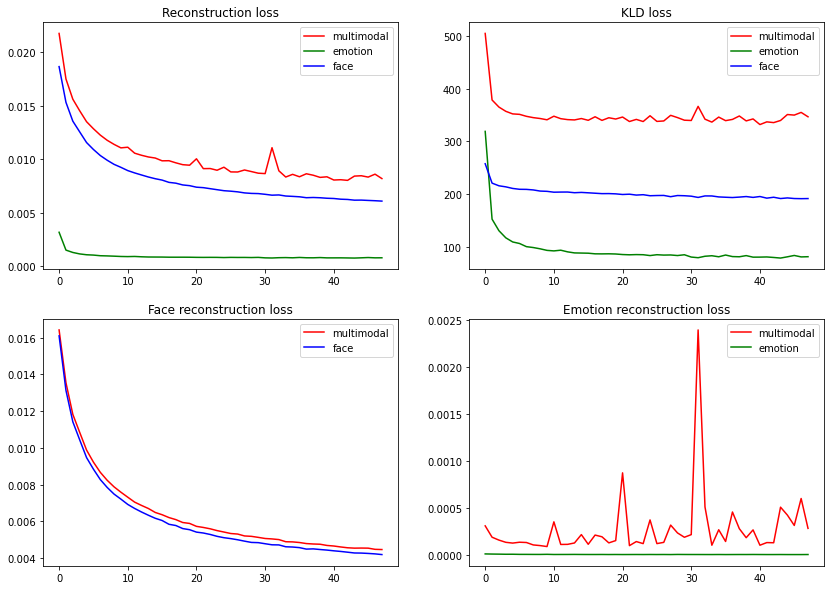

In [11]:
loaded_data = torch.load("../trained_models/ravdess_mvae_data_8kdrop_1-2.save")
training_losses_8kdrop_1_2 = loaded_data['training_loss']
U.print_losses(training_losses_8kdrop_1_2, 2)

In [12]:
loaded_data = torch.load("../trained_models/ravdess_mvae_data_8k_altloss_01.save")
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

MultimodalVariationalAutoencoder(
  (_face_encoder): Encoder(
    (conv1): ResDown(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (AvePool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (conv2): ResDown(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_si

In [13]:
import matplotlib.pyplot as plt
Rd.emocat

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

surprised
disgust


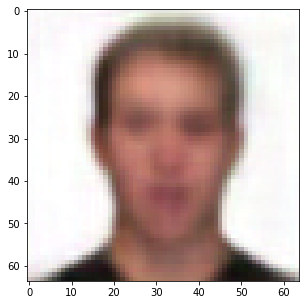

In [106]:
emotion = 7
print(Rd.emocat[emotion])

emotion = torch.tensor([emotion]).to('cuda')
plt.figure(figsize = (5,5))
r_image, _, _, _ = model(faces=None, emotions=emotion)
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
r_image = torch.clamp(r_image, min=0, max=1)
r_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.imshow(r_image)
print((Rd.emocat[torch.argmax(r_emotion.cpu()).item()]))